## Import packages

In [59]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import ERA5_functions as era_fncts
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [4]:
aht_ds = xr.open_dataset('aht_time_series/era5_aht_time_series.nc')

### Make a possible paper figure on AHT distributions and seasons

In [12]:
seasons = ['DJF', 'JJA', 'MAM', 'SON']

season_colors = ['blue', 'red', 'green', 'orange']

season_color_dict = dict(zip(seasons, season_colors))

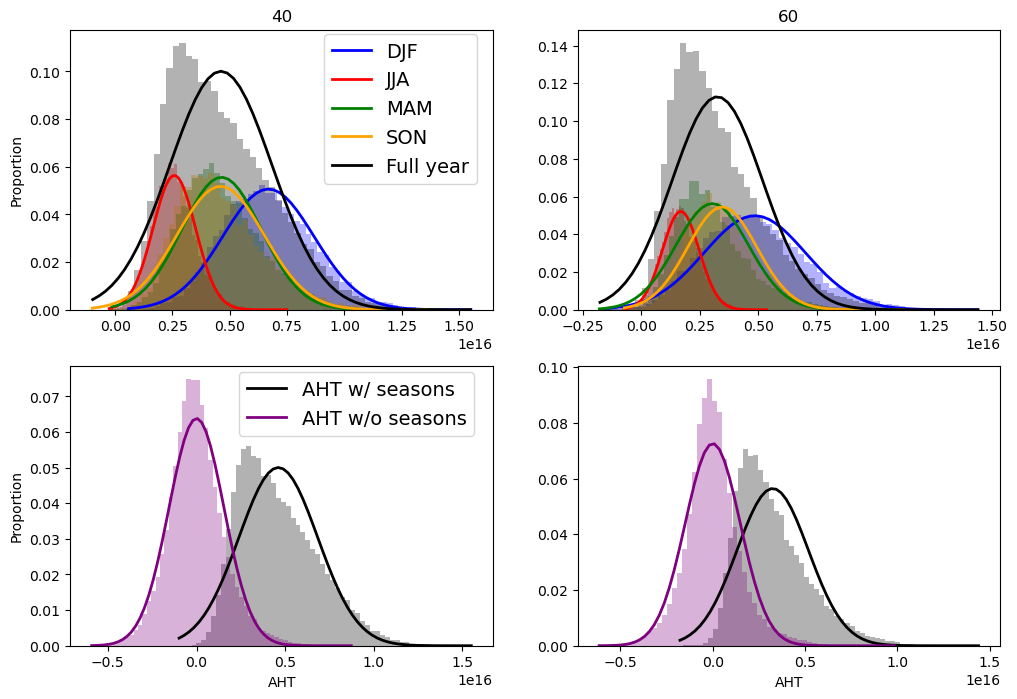

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

which_lat1 = 40
which_lat2 = 60


eddy_aht_grouped = aht_ds.eddy_aht.groupby('time.season')
for sea in seasons:
    eddy_aht = eddy_aht_grouped[sea]
    eddy_aht1 = eddy_aht.sel(latitude=which_lat1)
    eddy_aht2 = eddy_aht.sel(latitude=which_lat2)
    
    era_fncts.plot_hist_and_gauss(axs[0,0], eddy_aht1, season_color_dict[sea], label=sea)
    
    era_fncts.plot_hist_and_gauss(axs[0,1], eddy_aht2, season_color_dict[sea])


full_year_data1 = aht_ds.eddy_aht.sel(latitude=which_lat1)
era_fncts.plot_hist_and_gauss(axs[0,0], full_year_data1, 'k', scale_up=2, label='Full year')


full_year_data2 = aht_ds.eddy_aht.sel(latitude=which_lat2)
era_fncts.plot_hist_and_gauss(axs[0,1], full_year_data2, 'k', scale_up=2)


era_fncts.plot_hist_and_gauss(axs[1,0], aht_ds.eddy_aht.sel(latitude=which_lat1), 'k')
era_fncts.plot_hist_and_gauss(axs[1,0], aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1), 'purple')

era_fncts.plot_hist_and_gauss(axs[1,1], aht_ds.eddy_aht.sel(latitude=which_lat2), 'k',
                   label='AHT w/ seasons')
era_fncts.plot_hist_and_gauss(axs[1,1], aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2), 'purple',
                   label='AHT w/o seasons')


axs[0,0].set_ylabel('Proportion')
axs[1,0].set_ylabel('Proportion')

axs[1,0].set_xlabel('AHT')
axs[1,1].set_xlabel('AHT')

axs[0,0].set_title(str(which_lat1))
axs[0,1].set_title(str(which_lat2))


#plt.plot(lat+200, value[0]/conv_pw, color='k', label='Total AHT')
#plt.plot(lat+200, value[0]/conv_pw, ':', color='k', label='TE')
#plt.plot(lat+200, value[0]/conv_pw, '--', color='k', label='SE')
#plt.plot(lat+200, value[0]/conv_pw, '.', color='k', label='MMC')
 
lines1 = axs[0,0].get_lines()
lines2 = axs[1,1].get_lines()
include1=[0, 1, 2, 3, 4]
include2=[0, 1]
#include = [-1]
loc1=[-.6, 1.65]
loc2=[-.8, 0.75]

leg1=plt.legend([lines1[i] for i in include1],[lines1[i].get_label() for i in include1],
                loc=loc1, fontsize=14)
leg2=plt.legend([lines2[i] for i in include2],[lines2[i].get_label() for i in include2],
                loc=loc2, fontsize=14)

plt.gca().add_artist(leg1)

#plt.savefig('figures/2_8_22_meeting/eddy_aht_dist_with_seasons_paper_fig')

plt.show()


### Plot a distribution of AHT at one latitude and color by month

DJF mean is : 2.522071611176633 and std is: 0.8989581525611224
JJA mean is : -2.151280840679224 and std is: 0.9821708587734761
MAM mean is : 0.07426644909027406 and std is: 1.2109904473830693
SON mean is : -0.0754533265897411 and std is: 1.4231738128765297


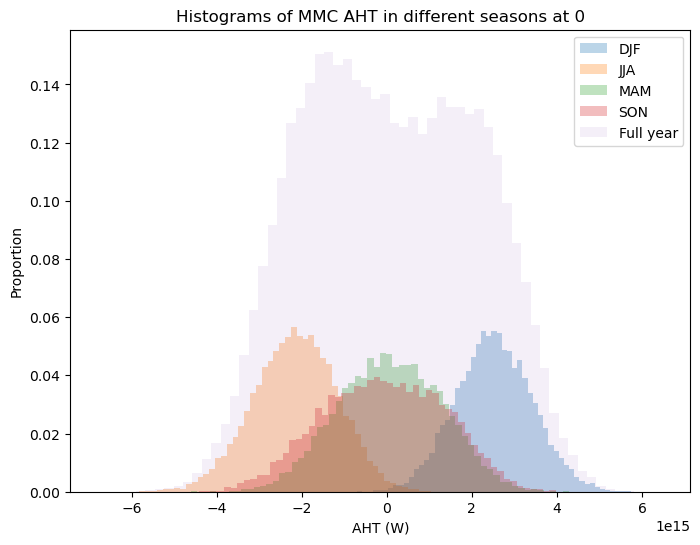

In [6]:
plt.figure(figsize=(8,6))

which_lat = 0

eddy_aht_grouped = aht_ds.mmc_aht.sel(latitude=which_lat).groupby('time.season')
#print(eddy_aht_grouped)
for sea in ['DJF', 'JJA', 'MAM', 'SON']:
    eddy_aht = eddy_aht_grouped[sea]
    print(sea + ' mean is : ' + str(np.mean(eddy_aht.values/1e15))+ ' and std is: ' + str(np.std(eddy_aht.values/1e15)))
    plt.hist(eddy_aht, weights=np.ones(len(eddy_aht)) / len(eddy_aht), bins=60, alpha=0.3, label=sea)
   
full_year_data = aht_ds.mmc_aht.sel(latitude=which_lat)
plt.hist(full_year_data, weights=4*np.ones(len(full_year_data)) / len(full_year_data), bins=60, alpha=0.1, label='Full year')
plt.legend(loc=0)
plt.xlabel('AHT (W)')

plt.ylabel('Proportion')

plt.title('Histograms of MMC AHT in different seasons at ' + str(which_lat))

#plt.savefig('figures/2_8_22_meeting/mmc_aht_distributions_seasons_' + str(which_lat) +'deg')

plt.show()

### Make some dummy data to show how 4 normal Gaussians can re-create a skewed total

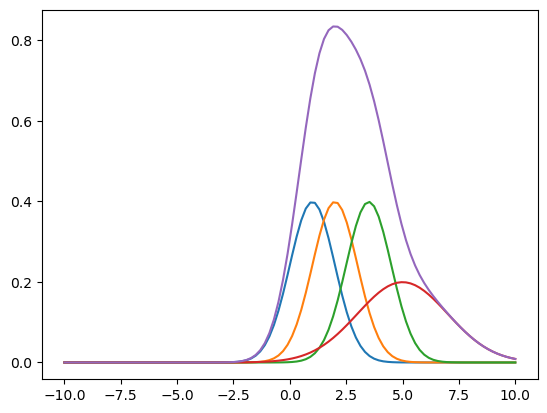

In [7]:
x_space = np.linspace(-10, 10, 100)

sigma_value = 1
# Fit to normal distribution
mu1, sigma1 = 1, sigma_value
mu2, sigma2 = 2, sigma_value
mu3, sigma3 = 3.5, sigma_value
mu4, sigma4 = 5, sigma_value + 1
# The pdf should not normed anymore but scaled the same way as the data
#y = mlab.normpdf(bin_middles, mu, sigma)*bin_width
gaus1 = sc.norm.pdf(x_space, mu1, sigma1)
gaus2 = sc.norm.pdf(x_space, mu2, sigma2)
gaus3 = sc.norm.pdf(x_space, mu3, sigma3)
gaus4 = sc.norm.pdf(x_space, mu4, sigma4)

plt.plot(x_space, gaus1)
plt.plot(x_space, gaus2)
plt.plot(x_space, gaus3)
plt.plot(x_space, gaus4)
plt.plot(x_space, gaus1 + gaus2 + gaus3 + gaus4)

#plt.savefig('figures/2_8_22_meeting/idealized_gussians_aht_distributions')
plt.show()